##**About The Dataset**
- The Telco customer churn data contains information about a company that provides phone and Internet services to over 7000 customers in California.

- The raw data contains 7043 rows (customers) and 21 columns (features).

##**Column Metadata:**


**customerID:**
Customer ID

**gender:**
Whether the customer is a male or a female

**SeniorCitizen:**
Whether the customer is a senior citizen or not (1, 0)

**Partner:**
Whether the customer has a partner or not (Yes, No)

**Dependents:**
Whether the customer has dependents or not (Yes, No)

**tenure:**
Number of months the customer has stayed with the company

**PhoneService:**
Whether the customer has a phone service or not (Yes, No)

**MultipleLines:**
Whether the customer has multiple lines or not (Yes, No, No phone service)

**InternetService:**
Customer’s internet service provider (DSL, Fiber optic, No)

**OnlineSecurity:**
Whether the customer has online security or not (Yes, No, No internet service)

 ## Import the necessary libraries.

In [1]:
!pip install pyspark

In [2]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

- Create a Spark Session.

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1724603341767'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.host', '5b91d0f6f1aa'),
 ('spark.executor.id

## Load and Clean The Dataset

In [5]:
df_spark = spark.read.csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)

In [6]:
df_spark.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [7]:
df_spark.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'string'),
 ('Churn', 'string')]

In [8]:
df_spark.describe()

DataFrame[summary: string, customerID: string, gender: string, SeniorCitizen: string, Partner: string, Dependents: string, tenure: string, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: string, TotalCharges: string, Churn: string]

In [9]:
df_spark.take(2)

[Row(customerID='7590-VHVEG', gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges='29.85', Churn='No'),
 Row(customerID='5575-GNVDE', gender='Male', SeniorCitizen=0, Partner='No', Dependents='No', tenure=34, PhoneService='Yes', MultipleLines='No', InternetService='DSL', OnlineSecurity='Yes', OnlineBackup='No', DeviceProtection='Yes', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='One year', PaperlessBilling='No', PaymentMethod='Mailed check', MonthlyCharges=56.95, TotalCharges='1889.5', Churn='No')]

In [10]:
df_spark.count()

7043

In [11]:
# check for null values
for col in df_spark.columns:
  print(col, "\t", "with null values: ", df_spark.filter(df_spark[col].isNull()).count())


customerID 	 with null values:  0
gender 	 with null values:  0
SeniorCitizen 	 with null values:  0
Partner 	 with null values:  0
Dependents 	 with null values:  0
tenure 	 with null values:  0
PhoneService 	 with null values:  0
MultipleLines 	 with null values:  0
InternetService 	 with null values:  0
OnlineSecurity 	 with null values:  0
OnlineBackup 	 with null values:  0
DeviceProtection 	 with null values:  0
TechSupport 	 with null values:  0
StreamingTV 	 with null values:  0
StreamingMovies 	 with null values:  0
Contract 	 with null values:  0
PaperlessBilling 	 with null values:  0
PaymentMethod 	 with null values:  0
MonthlyCharges 	 with null values:  0
TotalCharges 	 with null values:  0
Churn 	 with null values:  0


- There is no null values 😆

In [12]:
#converts the Churn column from categorical values (Yes or No) to numerical values (1 for “Yes” and 0 for No).
df_spark = df_spark.withColumn("Churn", when(df_spark.Churn == "Yes", 1).otherwise(0))

In [13]:
df_spark.head()

Row(customerID='7590-VHVEG', gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges='29.85', Churn=0)

 Churn=0 Yes! I succssed

## Exploratory Data Analysis
- I will be performe Exploratory data analysis to observe the behavior for users who stayed vs users who churned.

## EDA for Users that Stayed vs Users that Churned

In [14]:
# convert to pandas for visualisation
df_pandas = df_spark.toPandas()

In [15]:
# groupby churn to get counts
df_churn = df_spark.select(['customerID', 'Churn']).groupBy('Churn').count()

In [16]:
df_churn.show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 1869|
|    0| 5174|
+-----+-----+



In [17]:
df_churn = df_churn.toPandas()

<ipython-input-18-babe74e38916>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Churned','Stayed'])


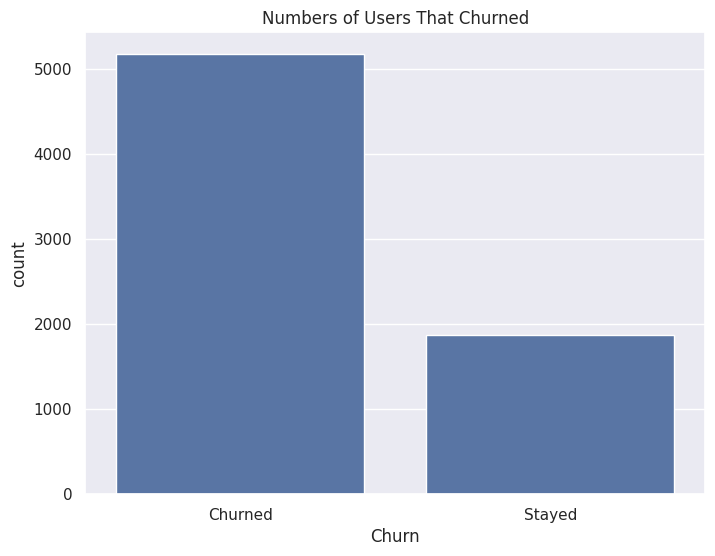

In [18]:
# plot the number of users that churned
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'Churn', y='count')
ax.set_xticklabels(['Churned','Stayed'])
plt.title("Numbers of Users That Churned");

In [19]:
# calculate churn rate
1869/(5174+1869)*100


26.536987079369588

- **Observation:**
From the data, we can observe that 26.54% of users churned, while 73.46% of users stayed.
This indicates that a significant majority of users (over 70%) are retained, which is a positive sign. However, there is still a notable portion of users (around 27%) who are leaving, suggesting there may be areas for improvement in user retention strategies.

## Gender Analysis: Churned Users vs. Retained Users
Let’s explore whether gender influenced the likelihood of users churning compared to those who remained with the service.

In [20]:
# create gender df grouped by churn and gender
df_gender = df_spark.select(['customerID', 'Churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [21]:
# show gender df
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|  Male|    1|  930|
|Female|    0| 2549|
|  Male|    0| 2625|
|Female|    1|  939|
+------+-----+-----+



In [22]:
# convert to pandas for visualisation
df_gender = df_gender.toPandas()

In [23]:
# order for the visualisation
df_gender = df_gender.sort_values('count', ascending = False)

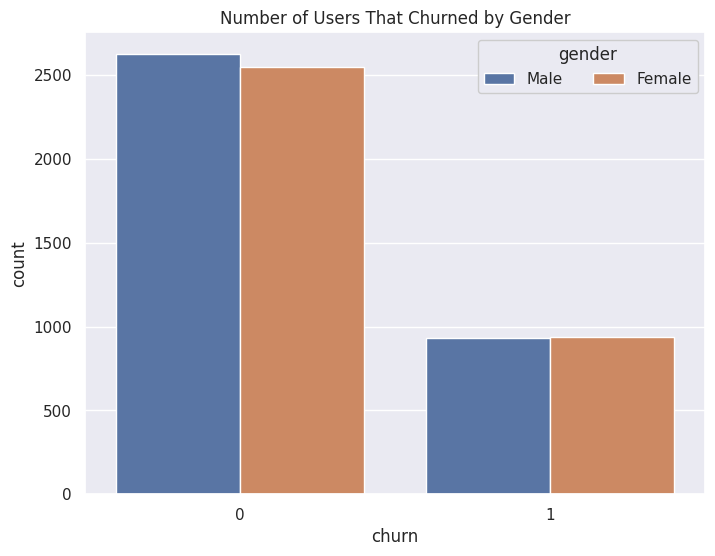

In [24]:
# seaborn barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users That Churned by Gender");

In [25]:
# fmale churn rate
939/(2549+939)

0.26920871559633025

In [26]:
# male churn rate
930/(2625+930)

0.2616033755274262

**Observation:**
- The churn rate for female users is 26.9%, while the churn rate for male users is 26.2%.
- The difference in churn rates between female and male users is relatively small, with female users having a slightly higher churn rate by 0.7%.
-This suggests that gender does not have a significant impact on the likelihood of users churning, as the rates are quite similar for both groups.

## Contract Analysis: Churned Users vs. Retained Users
Let’s investigate whether having a contract influenced the likelihood of users churning compared to those who remained with the service.

In [27]:
df_level = df_spark.select(['customerID', 'Churn', 'Contract']).dropDuplicates().groupBy('Contract','Churn').count()

In [28]:
df_level.show()

+--------------+-----+-----+
|      Contract|Churn|count|
+--------------+-----+-----+
|Month-to-month|    1| 1655|
|      One year|    1|  166|
|      One year|    0| 1307|
|      Two year|    1|   48|
|      Two year|    0| 1647|
|Month-to-month|    0| 2220|
+--------------+-----+-----+



In [29]:
# convert to pandas for visualisation
df_level = df_level.toPandas()

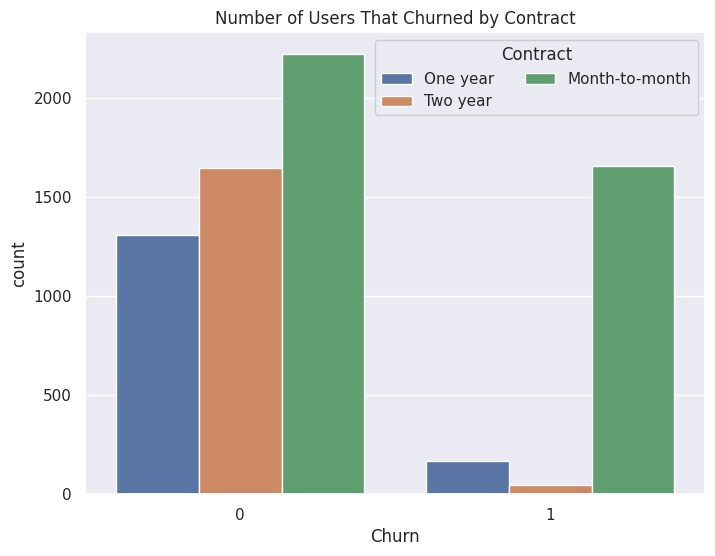

In [30]:
# plot the barplot using seaborn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level, x = 'Churn', y='count', hue = 'Contract')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'Contract')
plt.title("Number of Users That Churned by Contract");

In [31]:
# Month-to-month churn rate
1655/(2220+1655)

0.4270967741935484

In [32]:
# One year churn rate
166/(1307+166)

0.11269517990495587

In [33]:
# Two year churn rate
48/(1647+48)

0.02831858407079646

**Observation**:
From the data, it is clear that the type of contract significantly impacts the churn rate:

- Month-to-month contracts have the highest churn rate at 42.7%. This suggests that users with more flexible, short-term commitments are more likely to discontinue the service.
- One-year contracts show a much lower churn rate of 11.2%, indicating that users with a longer commitment are less likely to leave within the first year.
- Two-year contracts have the lowest churn rate at 2.83%, demonstrating that users with the longest commitments are the most likely to stay.

This pattern suggests that longer contract durations are associated with higher user retention. Encouraging users to opt for longer-term contracts could be an effective strategy to reduce churn rates.



##Service Analysis: Churned Users vs. Retained Users

Let’s examine whether the type of service, such as InternetService or PhoneService, influenced the likelihood of users churning compared to those who remained with the service.

In [34]:
df_Servies = df_spark.select(['customerID', 'Churn', 'PhoneService','InternetService']).dropDuplicates().groupBy('InternetService','PhoneService','Churn').count()

In [35]:
df_Servies.show()

+---------------+------------+-----+-----+
|InternetService|PhoneService|Churn|count|
+---------------+------------+-----+-----+
|    Fiber optic|         Yes|    0| 1799|
|            DSL|          No|    1|  170|
|             No|         Yes|    1|  113|
|             No|         Yes|    0| 1413|
|            DSL|         Yes|    1|  289|
|            DSL|          No|    0|  512|
|            DSL|         Yes|    0| 1450|
|    Fiber optic|         Yes|    1| 1297|
+---------------+------------+-----+-----+



In [36]:
# convert to pandas for visualisation
df_Servies = df_Servies.toPandas()

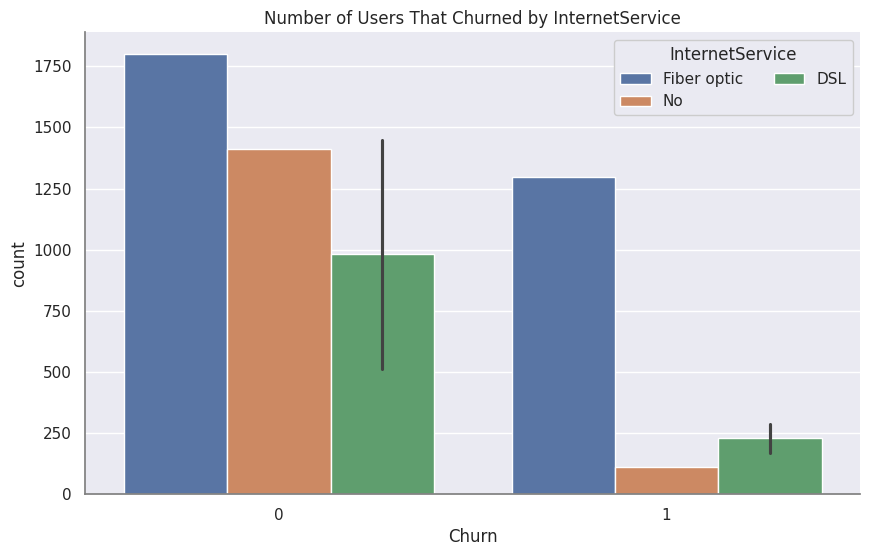

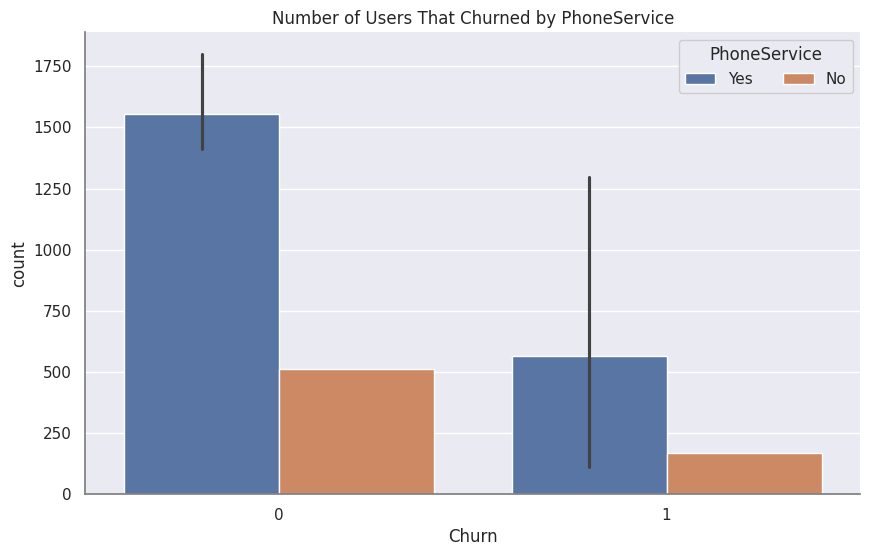

In [37]:
# plot the barplot using seaborn
plt.figure(figsize = [10,6])
ax = sns.barplot(data = df_Servies, x = 'Churn', y='count', hue = 'InternetService')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'InternetService')
plt.title("Number of Users That Churned by InternetService");
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

# plot the barplot using seaborn
plt.figure(figsize = [10,6])
ax = sns.barplot(data = df_Servies, x = 'Churn', y='count', hue = 'PhoneService')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'PhoneService')
plt.title("Number of Users That Churned by PhoneService");
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')


In [38]:
# fiber optic with phone service churn rate
1297/(1297 + 1799)

0.4189276485788114

In [39]:
#DSL without phone service churn rate
170/(170 + 512)

0.24926686217008798

In [40]:
#No Internet with phone service churn rate
113/(113 + 1413)

0.07404980340760157

In [41]:
#DSL with phone service churn rate
289/(289 + 1450)

0.16618746405980447

**Observation:**
- Fiber optic with Phone Service has the highest churn rate at 41.9%, indicating that a significant portion of users with this combination are leaving the service.

- DSL without Phone Service has a churn rate of 24.9%, which is lower than Fiber optic but still notable.

- No Internet with Phone Service has the lowest churn rate at 7.4%, suggesting that users with only phone service are the most likely to stay.
- DSL with Phone Service has a churn rate of 16.6%, indicating a moderate level of churn compared to the other categories.

These observations suggest that users with Fiber optic internet are more likely to churn, especially when they also have phone service. In contrast, users with only phone service and no internet are the most likely to remain with the service.

**This could indicate that the type of internet service plays a significant role in user retention.**

## Payment Method Analysis: Churned Users vs. Retained Users

Let’s analyze whether the payment method had an impact on the likelihood of users churning compared to those who remained with the service.

In [42]:
PaymentMethod = df_spark.select(['customerID', 'Churn','PaymentMethod']).dropDuplicates().groupBy('PaymentMethod','Churn').count()

In [43]:
PaymentMethod.show()

+--------------------+-----+-----+
|       PaymentMethod|Churn|count|
+--------------------+-----+-----+
|Credit card (auto...|    1|  232|
|        Mailed check|    0| 1304|
|Bank transfer (au...|    0| 1286|
|    Electronic check|    0| 1294|
|Bank transfer (au...|    1|  258|
|        Mailed check|    1|  308|
|    Electronic check|    1| 1071|
|Credit card (auto...|    0| 1290|
+--------------------+-----+-----+



In [44]:
# convert to pandas for visualisation
PaymentMethod = PaymentMethod.toPandas()

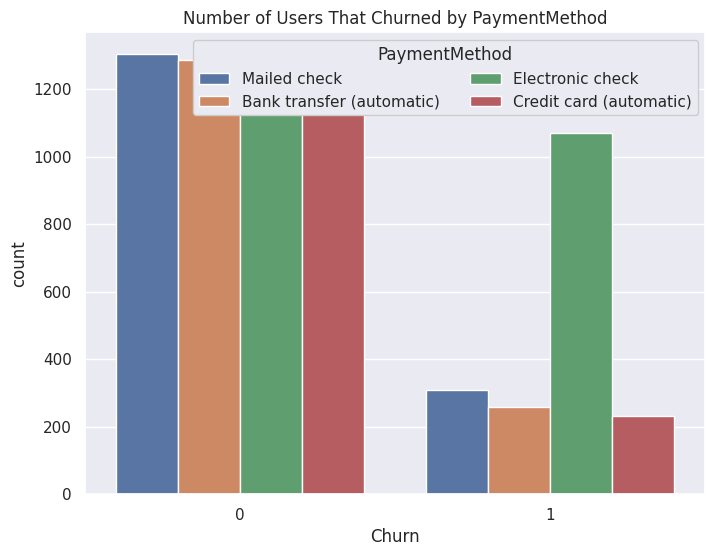

In [45]:
# plot the barplot using seaborn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = PaymentMethod, x = 'Churn', y='count', hue = 'PaymentMethod')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'PaymentMethod')
plt.title("Number of Users That Churned by PaymentMethod");

In [46]:
#credit card auto churn rate
232 / (232 + 1290)

0.15243101182654403

In [47]:
#electronic check churn rate
1071 / (1071 + 1294)

0.4528541226215645

In [48]:
#mailed check churn rate
308 / (308 + 1304)

0.19106699751861042

In [49]:
#bank transfer auto churn rate
258 / (258 + 1286)


0.16709844559585493

**Observation**:
- **Electronic check** has the highest churn rate at 45.3%, indicating that users who pay via electronic check are the most likely to leave the service.
- **Mailed check** has a churn rate of 19.1%, which is the second highest among the payment methods.
- **Bank transfer** (automatic) has a churn rate of 16.7%, showing a moderate level of churn.
- **Credit card** (automatic) has the lowest churn rate at 15.2%, suggesting that users who pay via automatic credit card payments are the least likely to churn.

These observations suggest that automatic payment methods, particularly credit card payments, are associated with lower churn rates. Encouraging users to switch to automatic payment methods could potentially improve retention rates.

# Senior Citizen Analysis: Churn vs. Retention
Let’s analyze how being a senior citizen affects the likelihood of customer churn.

In [50]:
df_spark.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [51]:
SeniorCitizen = df_spark.select(['customerID', 'Churn','SeniorCitizen']).dropDuplicates().groupBy('SeniorCitizen','Churn').count()

In [52]:
SeniorCitizen.show()

+-------------+-----+-----+
|SeniorCitizen|Churn|count|
+-------------+-----+-----+
|            1|    0|  666|
|            1|    1|  476|
|            0|    0| 4508|
|            0|    1| 1393|
+-------------+-----+-----+



In [53]:
SeniorCitizen=SeniorCitizen.toPandas()

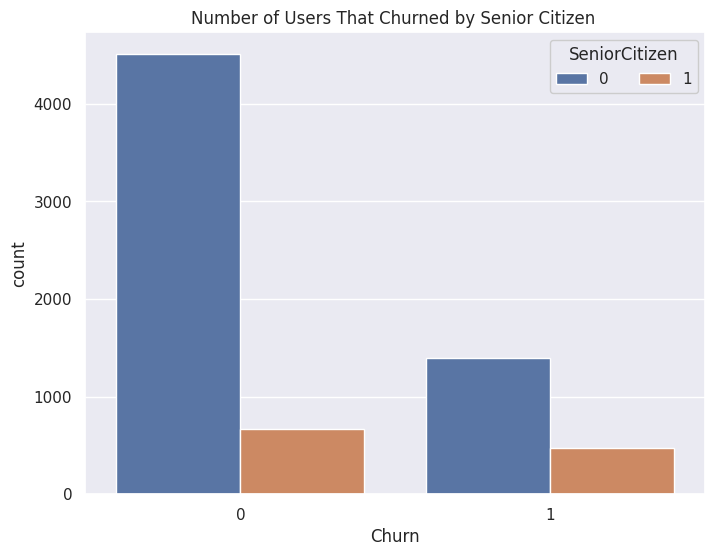

In [54]:
# plot the barplot using seaborn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = SeniorCitizen, x = 'Churn', y='count', hue = 'SeniorCitizen')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'SeniorCitizen')

plt.title("Number of Users That Churned by Senior Citizen ");


In [55]:
#The churn rate for senior citizens
476/(666 + 476)

0.4168126094570928

In [56]:
#The churn rate for non-senior citizens
1393/(4508 + 1393)

0.23606168446026096

## Observation
- Senior citizens have a higher churn rate (41.7%) compared to non-senior citizens (23.6%).

This suggests that senior citizens are more likely to discontinue the service compared to non-senior citizens.


## Feature Engineering
Now that EDA has been performed, we can build out the features that seem most promising to train our model on.

The features we will build out are:


**Categorical:**

* gender

*   Partner
*   Dependents
PhoneService

*   MultipleLines

*   InternetService

*   OnlineSecurity
*   OnlineBackup
* eviceProtection
* TechSupport
* StreamingTV
* StreamingMovies
* Contract
* PaperlessBilling
* PaymentMethod

**Numerical:**

* tenure
* MonthlyCharges
* TotalCharges
* SeniorCitizen

I will also then add a churn label and join these all together. This will create a DataFrame where each row represents information pertaining to each individual customer. Once we drop the customerID, this DataFrame can be vectorized, standardized, and fed into our different machine learning algorithms.

First, I will take the categorical variables and convert them into numeric variables.

**Gender**

In [57]:
gender_df = df_spark.select(['customerID', 'gender']).dropDuplicates()

In [58]:
gender_df=gender_df.withColumn('gender',when(gender_df.gender=='Female',1).otherwise(0))

In [59]:
gender_df.count()

7043

In [60]:
# check
gender_df.show(20)

+----------+------+
|customerID|gender|
+----------+------+
|2240-HSJQD|     0|
|8896-RAZCR|     1|
|3030-ZKIWL|     0|
|7627-JKIAZ|     1|
|6891-JPYFF|     1|
|5461-QKNTN|     0|
|7675-OZCZG|     1|
|7198-GLXTC|     0|
|8237-ULIXL|     1|
|4231-LZUYM|     1|
|4550-VBOFE|     0|
|1303-SRDOK|     1|
|5197-LQXXH|     1|
|1120-BMWUB|     1|
|2883-ILGWO|     0|
|0396-HUJBP|     1|
|9026-RNUJS|     0|
|2897-DOVND|     0|
|3274-NSDWE|     1|
|6543-XRMYR|     1|
+----------+------+
only showing top 20 rows



**PaymentMethod**

In [61]:
df2 = df_spark.select(['customerID', 'PaymentMethod']).dropDuplicates()

In [62]:
df2.show()

+----------+--------------------+
|customerID|       PaymentMethod|
+----------+--------------------+
|6467-CHFZW|    Electronic check|
|4443-EMBNA|Bank transfer (au...|
|9396-ZSFLL|        Mailed check|
|0139-IVFJG|    Electronic check|
|4335-BSMJS|Credit card (auto...|
|3643-AHCFP|Bank transfer (au...|
|2176-LVPNX|        Mailed check|
|7979-CORPM|Credit card (auto...|
|9337-SRRNI|Credit card (auto...|
|9546-CQJSU|    Electronic check|
|1958-RNRKS|    Electronic check|
|5136-KCKGI|        Mailed check|
|7548-SEPYI|    Electronic check|
|0023-UYUPN|    Electronic check|
|8348-HFYIV|    Electronic check|
|2250-IVBWA|    Electronic check|
|1400-WIVLL|    Electronic check|
|2817-LVCPP|Credit card (auto...|
|3896-ZVNET|        Mailed check|
|4324-BZCKL|        Mailed check|
+----------+--------------------+
only showing top 20 rows



In [63]:
df2 = df2.withColumn('PaymentMethod',
                   when(df2.PaymentMethod == 'Credit card (automatic)', 1)
                   .when(df2.PaymentMethod == 'Mailed check', 2)
                   .when(df2.PaymentMethod == 'Bank transfer (automatic)', 3)
                   .when(df2.PaymentMethod == 'Electronic check', 4)
                   .otherwise(0))

In [64]:
#check
df2.show()

+----------+-------------+
|customerID|PaymentMethod|
+----------+-------------+
|6467-CHFZW|            4|
|4443-EMBNA|            3|
|9396-ZSFLL|            2|
|0139-IVFJG|            4|
|4335-BSMJS|            1|
|3643-AHCFP|            3|
|2176-LVPNX|            2|
|7979-CORPM|            1|
|9337-SRRNI|            1|
|9546-CQJSU|            4|
|1958-RNRKS|            4|
|5136-KCKGI|            2|
|7548-SEPYI|            4|
|0023-UYUPN|            4|
|8348-HFYIV|            4|
|2250-IVBWA|            4|
|1400-WIVLL|            4|
|2817-LVCPP|            1|
|3896-ZVNET|            2|
|4324-BZCKL|            2|
+----------+-------------+
only showing top 20 rows



**InternetService**

In [65]:
InternetService_df= df_spark.select(['customerID', 'InternetService']).dropDuplicates()

In [66]:
InternetService_df.show()

+----------+---------------+
|customerID|InternetService|
+----------+---------------+
|3413-BMNZE|            DSL|
|0191-ZHSKZ|            DSL|
|0278-YXOOG|             No|
|2656-FMOKZ|    Fiber optic|
|8098-LLAZX|    Fiber optic|
|0979-MOZQI|            DSL|
|5461-QKNTN|    Fiber optic|
|2408-TZMJL|    Fiber optic|
|2761-OCIAX|    Fiber optic|
|6732-VAILE|            DSL|
|5155-AZQPB|            DSL|
|8311-UEUAB|            DSL|
|9168-INPSZ|    Fiber optic|
|6670-MFRPK|    Fiber optic|
|2792-LSHWX|    Fiber optic|
|5533-NHFRF|            DSL|
|0635-WKOLD|            DSL|
|6838-HVLXG|             No|
|7587-RZNME|            DSL|
|3082-YVEKW|            DSL|
+----------+---------------+
only showing top 20 rows



In [67]:
InternetService_df = InternetService_df.withColumn('InternetService',
                   when(InternetService_df.InternetService == 'Fiber optic', 1)
                   .when(InternetService_df.InternetService == 'DSL', 2)
                   .otherwise(0))

In [68]:
InternetService_df.show()

+----------+---------------+
|customerID|InternetService|
+----------+---------------+
|3413-BMNZE|              2|
|0191-ZHSKZ|              2|
|0278-YXOOG|              0|
|2656-FMOKZ|              1|
|8098-LLAZX|              1|
|0979-MOZQI|              2|
|5461-QKNTN|              1|
|2408-TZMJL|              1|
|2761-OCIAX|              1|
|6732-VAILE|              2|
|5155-AZQPB|              2|
|8311-UEUAB|              2|
|9168-INPSZ|              1|
|6670-MFRPK|              1|
|2792-LSHWX|              1|
|5533-NHFRF|              2|
|0635-WKOLD|              2|
|6838-HVLXG|              0|
|7587-RZNME|              2|
|3082-YVEKW|              2|
+----------+---------------+
only showing top 20 rows



**PhoneService**

In [69]:
PhoneService_df= df_spark.select(['customerID', 'PhoneService']).dropDuplicates()

In [70]:
PhoneService_df.show()

+----------+------------+
|customerID|PhoneService|
+----------+------------+
|9286-BHDQG|          No|
|6496-JDSSB|         Yes|
|0516-UXRMT|         Yes|
|5845-BZZIB|         Yes|
|9092-GDZKO|         Yes|
|0115-TFERT|         Yes|
|4741-WWJQZ|         Yes|
|8800-ZKRFW|         Yes|
|5816-JMLGY|         Yes|
|4795-KTRTH|         Yes|
|7833-PKIHD|         Yes|
|4079-VTGLK|         Yes|
|4074-SJFFA|         Yes|
|6402-SSEJG|          No|
|3763-GCZHZ|         Yes|
|0233-FTHAV|         Yes|
|3148-AOIQT|         Yes|
|8043-PNYSD|         Yes|
|7711-YIJWC|         Yes|
|9753-OYLBX|         Yes|
+----------+------------+
only showing top 20 rows



In [71]:
PhoneService_df=PhoneService_df.withColumn('PhoneService',
                                           when(PhoneService_df.PhoneService=='Yes',1).otherwise(0))

In [72]:
PhoneService_df.show()

+----------+------------+
|customerID|PhoneService|
+----------+------------+
|9286-BHDQG|           0|
|6496-JDSSB|           1|
|0516-UXRMT|           1|
|5845-BZZIB|           1|
|9092-GDZKO|           1|
|0115-TFERT|           1|
|4741-WWJQZ|           1|
|8800-ZKRFW|           1|
|5816-JMLGY|           1|
|4795-KTRTH|           1|
|7833-PKIHD|           1|
|4079-VTGLK|           1|
|4074-SJFFA|           1|
|6402-SSEJG|           0|
|3763-GCZHZ|           1|
|0233-FTHAV|           1|
|3148-AOIQT|           1|
|8043-PNYSD|           1|
|7711-YIJWC|           1|
|9753-OYLBX|           1|
+----------+------------+
only showing top 20 rows



**SeniorCitizen**

In [73]:
SeniorCitizen_df=df_spark.select('customerID','SeniorCitizen')

In [74]:
SeniorCitizen_df.show()

+----------+-------------+
|customerID|SeniorCitizen|
+----------+-------------+
|7590-VHVEG|            0|
|5575-GNVDE|            0|
|3668-QPYBK|            0|
|7795-CFOCW|            0|
|9237-HQITU|            0|
|9305-CDSKC|            0|
|1452-KIOVK|            0|
|6713-OKOMC|            0|
|7892-POOKP|            0|
|6388-TABGU|            0|
|9763-GRSKD|            0|
|7469-LKBCI|            0|
|8091-TTVAX|            0|
|0280-XJGEX|            0|
|5129-JLPIS|            0|
|3655-SNQYZ|            0|
|8191-XWSZG|            0|
|9959-WOFKT|            0|
|4190-MFLUW|            0|
|4183-MYFRB|            0|
+----------+-------------+
only showing top 20 rows



**Label**

In [75]:
label=df_spark.select('customerID','Churn').groupby('customerID','Churn').count()

In [76]:
label=label.drop('count')

In [77]:
label.count()

7043

In [78]:
label=label.withColumnRenamed('Churn','label')

In [79]:
label.show()

+----------+-----+
|customerID|label|
+----------+-----+
|4767-HZZHQ|    0|
|2080-SRCDE|    0|
|3859-CVCET|    1|
|0042-RLHYP|    0|
|4945-RVMTE|    0|
|9546-CQJSU|    1|
|1925-GMVBW|    0|
|5628-FCGYG|    0|
|8064-RAVOH|    0|
|2809-ILCYT|    0|
|1465-WCZVT|    0|
|2739-CCZMB|    0|
|2696-RZVZW|    0|
|9220-CXRSC|    0|
|4626-OZDTJ|    0|
|0946-CLJTI|    1|
|5485-WUYWF|    1|
|4729-XKASR|    1|
|5480-TBGPH|    1|
|6413-XKKPU|    1|
+----------+-----+
only showing top 20 rows



## Construct Features Dataset

With our features identified, the next step is to merge them based on userId.

In [81]:
feature_df=gender_df.join(df2,['customerID']).join(InternetService_df,['customerID']).join(PhoneService_df,['customerID']).join(SeniorCitizen_df,['customerID']).join(label,['customerID'])

In [82]:
feature_df.show()

+----------+------+-------------+---------------+------------+-------------+-----+
|customerID|gender|PaymentMethod|InternetService|PhoneService|SeniorCitizen|label|
+----------+------+-------------+---------------+------------+-------------+-----+
|6467-CHFZW|     0|            4|              1|           1|            0|    1|
|4443-EMBNA|     1|            3|              0|           1|            0|    0|
|9396-ZSFLL|     1|            2|              2|           1|            0|    0|
|0139-IVFJG|     1|            4|              1|           1|            0|    0|
|4335-BSMJS|     1|            1|              0|           1|            0|    0|
|3643-AHCFP|     0|            3|              1|           1|            1|    1|
|2176-LVPNX|     1|            2|              2|           1|            1|    0|
|7979-CORPM|     0|            1|              1|           1|            0|    1|
|9337-SRRNI|     0|            1|              0|           1|            0|    0|
|954

In [83]:
feature_df=feature_df.drop('customerID')

In [84]:
feature_df.show()

+------+-------------+---------------+------------+-------------+-----+
|gender|PaymentMethod|InternetService|PhoneService|SeniorCitizen|label|
+------+-------------+---------------+------------+-------------+-----+
|     0|            4|              1|           1|            0|    1|
|     1|            3|              0|           1|            0|    0|
|     1|            2|              2|           1|            0|    0|
|     1|            4|              1|           1|            0|    0|
|     1|            1|              0|           1|            0|    0|
|     0|            3|              1|           1|            1|    1|
|     1|            2|              2|           1|            1|    0|
|     0|            1|              1|           1|            0|    1|
|     0|            1|              0|           1|            0|    0|
|     1|            4|              1|           1|            0|    1|
|     0|            4|              2|           1|            0

With our dataframe now containing all the necessary features for each user, we can proceed to integrate it into our model. However, we must first perform some preprocessing steps.


## Preprocessing

In [85]:
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- PaymentMethod: integer (nullable = false)
 |-- InternetService: integer (nullable = false)
 |-- PhoneService: integer (nullable = false)
 |-- SeniorCitizen: integer (nullable = true)
 |-- label: integer (nullable = false)



Next, we need to transform these columns into numerical data types, such as integers and floats, for use in our model. To maintain the DRY (Don’t Repeat Yourself) principle, we can write a function for this conversion.

In [86]:
for feature in feature_df.columns:
  feature_df=feature_df.withColumn(feature,feature_df[feature].cast('float'))

In [87]:
#check this works
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- PaymentMethod: float (nullable = false)
 |-- InternetService: float (nullable = false)
 |-- PhoneService: float (nullable = false)
 |-- SeniorCitizen: float (nullable = true)
 |-- label: float (nullable = false)



The next step in preprocessing is to convert our features into vectors.

Vector Assembler
The purpose of vector assembler is to tranform our features into a vector. The vector can then be standardised and fed into our chosen algorithms.

In [88]:
assembler = VectorAssembler(inputCols = ["gender", "PaymentMethod", "InternetService", "PhoneService", "SeniorCitizen"], outputCol = "vec_features")

In [89]:
feature_df=assembler.transform(feature_df)

In [90]:
feature_df.show()

+------+-------------+---------------+------------+-------------+-----+--------------------+
|gender|PaymentMethod|InternetService|PhoneService|SeniorCitizen|label|        vec_features|
+------+-------------+---------------+------------+-------------+-----+--------------------+
|   0.0|          4.0|            1.0|         1.0|          0.0|  1.0|[0.0,4.0,1.0,1.0,...|
|   1.0|          3.0|            0.0|         1.0|          0.0|  0.0|[1.0,3.0,0.0,1.0,...|
|   1.0|          2.0|            2.0|         1.0|          0.0|  0.0|[1.0,2.0,2.0,1.0,...|
|   1.0|          4.0|            1.0|         1.0|          0.0|  0.0|[1.0,4.0,1.0,1.0,...|
|   1.0|          1.0|            0.0|         1.0|          0.0|  0.0|[1.0,1.0,0.0,1.0,...|
|   0.0|          3.0|            1.0|         1.0|          1.0|  1.0|[0.0,3.0,1.0,1.0,...|
|   1.0|          2.0|            2.0|         1.0|          1.0|  0.0|[1.0,2.0,2.0,1.0,...|
|   0.0|          1.0|            1.0|         1.0|          0.0|  1.0

## Standardisation

In [91]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [92]:
scaler_model = scaler.fit(feature_df)

In [93]:
feature_df = scaler_model.transform(feature_df)

In [94]:
feature_df.head(2)

[Row(gender=0.0, PaymentMethod=4.0, InternetService=1.0, PhoneService=1.0, SeniorCitizen=0.0, label=1.0, vec_features=DenseVector([0.0, 4.0, 1.0, 1.0, 0.0]), features=DenseVector([0.0, 3.477, 1.3554, 3.3812, 0.0])),
 Row(gender=1.0, PaymentMethod=3.0, InternetService=0.0, PhoneService=1.0, SeniorCitizen=0.0, label=0.0, vec_features=DenseVector([1.0, 3.0, 0.0, 1.0, 0.0]), features=DenseVector([1.9999, 2.6078, 0.0, 3.3812, 0.0]))]

## Partitioning the Data into Training, Testing, and Validation Sets

In [95]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0| 1869|
|  0.0| 5174|
+-----+-----+



Splitting the Data into Training (60%), Validation (20%), and Test (20%) Sets

In [118]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:4225
Test Dataset:1453
Validation Dataset:1365


## Modelling

With the features DataFrame now containing only numeric variables,I will evaluate various machine learning classification algorithms, including:

* Logistic Regression
* Random Forest Classifier
* Gradient-Boosted Tree Classifier
* Linear Support Vector Machine
* Naive Bayes


These algorithms are suitable for churn prediction, a binary classification problem where customers either churn (1) or remain (0) within a specified period.

In [119]:
# instantiate all of our models and include a seed for reproduciblity where possible
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=1996)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=1996)
lsvc = LinearSVC(featuresCol = 'features', labelCol = 'label')
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')

In [120]:
#list of models
model_list = [lr,rf,gbt,lsvc,nb]

In [121]:
# evaluator we are using is multiclassclassificationevaluator to get the F1 scores
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [122]:
# for loop to go through all our models
for model in model_list:
    # get model name
    model_name = model.__class__.__name__

    # print training started
    print(model_name, 'training started')

    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()

    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')

    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')

    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 8.317015886306763 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.6784395398982949
The accuracy of the LogisticRegression model is: 0.7333333333333333
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 10.489774227142334 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.6725293203615935
The accuracy of the RandomForestClassifier model is: 0.7347985347985349
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 9.25431227684021 seconds
GBTClassifier predicting started
GBTClassifier predicting ended
F1 for GBTClassifier is: 0.7218667365572697
The accuracy of the GBTClassifier model is: 0.7413919413919414
LinearSVC training started
Linea

## Model Tuning for Best Models:
Now I can proceed with tuning the model using ParamGridBuilder and CrossValidator. I have chosen to go with the Naive Bayes model as it offers the best balance between F1 score, accuracy, and runtime efficiency. The Naive Bayes model achieved an F1 score of 0.6741 and an accuracy of 70.55%, with a runtime of just 3.77 seconds. In comparison, other models took significantly longer to run while achieving similar or slightly better scores.

**NaiveBayes**

In [123]:
#Let's see what parameters we can tune.
print(nb.explainParams())

featuresCol: features column name. (default: features, current: features)
labelCol: label column name. (default: label, current: label)
modelType: The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian. (default: multinomial)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
smoothing: The smoothing parameter, should be >= 0, default is 1.0 (default: 1.0)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class wit

In [128]:
# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.5, 1.0]) \
    .addGrid(nb.modelType, ['multinomial', 'bernoulli']) \
    .build()


crossval = CrossValidator(estimator=np,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [126]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [131]:
nb = NaiveBayes()

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.5, 1.0]) \
    .addGrid(nb.modelType, ['multinomial', 'bernoulli']) \
    .build()

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Set up the CrossValidator
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Use 5-fold cross-validation

# Fit the model
cvModel = crossval.fit(train)

# Make predictions on the test data
predictions = cvModel.transform(test)

# Evaluate the model
f1_score = evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")

Py4JJavaError: An error occurred while calling o6552.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 3102.0 failed 1 times, most recent failure: Lost task 1.0 in stage 3102.0 (TID 22834) (5b91d0f6f1aa executor driver): java.lang.RuntimeException: Vector values MUST be in {0, 1}, but got [0.0,0.8692516013428768,1.3553875846108099,3.3812086352456543,0.0]
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.RuntimeException: Vector values MUST be in {0, 1}, but got [0.0,0.8692516013428768,1.3553875846108099,3.3812086352456543,0.0]
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [129]:
# Fit the model
cvModel = crossval.fit(train)

AttributeError: module 'numpy' has no attribute 'fitMultiple'

In [ ]:
cvModel.avgMetrics

In [ ]:

# Make predictions on the test data
predictions = cvModel.transform(testData)

# Evaluate the model
f1_score = evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")

## Feature Importance:

In [ ]:
importances = best_model.featureImportances

In [ ]:
x_values = list(range(len(importances)))

In [ ]:
feature_list = list(['gender','PaymentMethod','InternetService','PhoneService','SeniorCitizen')

In [ ]:

plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');